# Import appropriate modules

In [2]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants
from scipy.linalg import expm

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

from tqdm.notebook import tqdm, trange

import itertools

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [3]:
def label_to_state_no(N,MF,k):
    return np.where((LABELS[:, 0] == N) & (LABELS[:, 1] == MF) & (LABELS[:, 2] == k))[0][0]

def state_no_to_uncoupled_label(state_no):
    i=0
    I1d = round(2*I1)
    I2d = round(2*I2)
    for n in range(0, N_MAX + 1):
        for mn in range(n,-(n+1),-1):
            for mi1 in range(I1d,-I1d-1,-2):
                for mi2 in range(I2d,-I2d-1,-2):
                    if i == state_no:
                        return (n,mn,mi1/2,mi2/2)
                    i+=1

In [4]:
def label_degeneracy(N,MF):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    I1d=round(2*I1)
    I2d=round(2*I2)
    for MN in range(-N,N+1):
        for M_I1d in range(-I1d,I1d+1,2):
            for M_I2d in range(-I2d,I2d+1,2):
                if 2*MN+M_I1d+M_I2d == 2*MF:
                    d+=1
    return d

# Define 'global' Constants

In [5]:
H_BAR = scipy.constants.hbar

I1 = Rb87Cs133["I1"]
I2 = Rb87Cs133["I2"]
D_0 = Rb87Cs133["d0"]
N_MAX=2

I = 0 #W/m^2
E = 0 #V/m

B_MIN_GAUSS = 0.01
B_MAX_GAUSS = 600
B_STEPS = 1200

settings_string = f'NMax{N_MAX}BMin{B_MIN_GAUSS}BMax{B_MAX_GAUSS}BSteps{B_STEPS}'
print(settings_string)

GAUSS = 1e4 # T
B_MIN = B_MIN_GAUSS / GAUSS # T
B_MAX = B_MAX_GAUSS / GAUSS # T

PULSE_TIME = 100 * 1e-6 # s

B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T 

NMax2BMin0.01BMax600BSteps1200


In [6]:
data = np.load(f'../precomputed/{settings_string}.npz')
ENERGIES = data['energies']
N_STATES = len(ENERGIES[0])
STATES = data['states']
LABELS=data['labels']
MAGNETIC_MOMENTS=data['magnetic_moments'] 
COUPLINGS_ZERO=data['coupling_matrix_zero']
COUPLINGS_MINUS=data['coupling_matrix_minus']
COUPLINGS_PLUS=data['coupling_matrix_plus']
COUPLINGS = COUPLINGS_ZERO+COUPLINGS_MINUS+COUPLINGS_PLUS
POLARISED_COUPLING = [COUPLINGS_ZERO,COUPLINGS_PLUS,COUPLINGS_MINUS]
UNPOLARISED_PAIR_FIDELITIES = data['unpolarised_pair_fidelities']
POLARISED_PAIR_FIDELITIES=data['polarised_pair_fidelities']

# Simulator

In [7]:
# Which states to simulate
chosen_states_labels = np.array([(0,4,1),(1,5,2),(2,4,4),(1,4,3)])
chosen_states_labels = LABELS

# Driven couplings between states
chosen_states_coupling_labels = np.array([(0,4,1),(1,5,2),(2,4,4),(1,4,3)])
chosen_coupling_labels = [
    (chosen_states_coupling_labels[0],chosen_states_coupling_labels[1]),
    (chosen_states_coupling_labels[1],chosen_states_coupling_labels[2]),
    (chosen_states_coupling_labels[3],chosen_states_coupling_labels[2]),
    (chosen_states_coupling_labels[0],chosen_states_coupling_labels[3]),
]

# With what desired rabi period
global_pulse_time = 1000 * 1e-6 #s
chosen_pulse_time = [global_pulse_time]*4

# At what magnetic field
chosen_bi = 1199 

# Simulation resolution
T_STEPS =  [314927,195931,65519,41443,21319,9391,50][0] 

# Simulation time length (how many Rabi periods to show)
TIME = chosen_pulse_time[0]*5

In [8]:
# Compute indices & mixin with molecular parameters
chosen_states_indices = np.array([label_to_state_no(*label) for label in chosen_states_labels])
chosen_number_of_states = len(chosen_states_indices)
chosen_states_coupling_subindices = [np.where((chosen_states_labels[:, 0] == N) & (chosen_states_labels[:, 1] == MF) & (chosen_states_labels[:, 2] == k))[0][0] for N,MF,k in chosen_states_coupling_labels]

In [10]:
# Get Angular Frequency Matrix Diagonal for each B
all_angular = ENERGIES[chosen_bi, :].real / H_BAR # [state]
angular = all_angular[chosen_states_indices]

all_couplings = COUPLINGS[chosen_bi]
couplings = all_couplings[:,chosen_states_indices][chosen_states_indices,:]

# Get driving frequencies & polarisations
driving = []
E_i = []
for (l1,l2), pulse_time in zip(chosen_coupling_labels, chosen_pulse_time):
    i1=label_to_state_no(*l1)
    i2=label_to_state_no(*l2)
    driving.append(np.abs(all_angular[i1]-all_angular[i2]))
    E_i.append((2*np.pi*H_BAR) / (D_0 * all_couplings[i1,i2] * pulse_time))
driving = np.array(driving)
E_i = np.array(E_i)

# Construct times
times, DT = np.linspace(0,TIME,num=T_STEPS,retstep=True)

# Construct kinetic time step operator (Matrix Diagonal)
T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )

# Construct potential fixed part time step operator 
ORDER = 5
V_TI_M = (-(1j)*D_0*couplings*DT)/H_BAR
V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

# Construct state vector
state_vector = np.zeros((T_STEPS,chosen_number_of_states), dtype=np.cdouble)
state_vector[0,chosen_states_coupling_subindices[0]] = np.sqrt(1)

for t_num in trange(T_STEPS-1):
    pres = E_i*np.cos(driving*times[t_num])
    V_TD_POWS = np.sum(pres)**(np.arange(ORDER))
    V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None],axis=0)
    
    DU = T_OP_DIAG[:,None] * V_OP[:,:] * T_OP_DIAG[None,:]
    state_vector[t_num+1] = DU @ state_vector[t_num]
    
probabilities = np.abs(state_vector[::50,:])**2

  0%|          | 0/314926 [00:00<?, ?it/s]

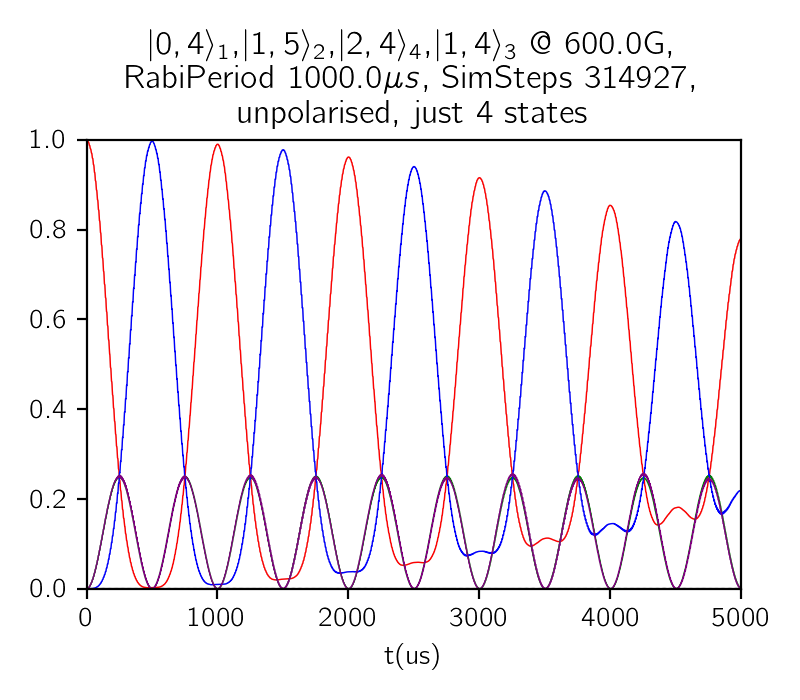

In [12]:
# Plot results
fig,ax = plt.subplots()
ax.set_xlabel('t(us)')
ax.set_ylim(0,1.0)
ax.set_xlim(0,TIME*1e6)
ax.set_title('$|{},{}\\rangle_{{{}}}$,$|{},{}\\rangle_{{{}}}$,$|{},{}\\rangle_{{{}}}$,$|{},{}\\rangle_{{{}}}$ @ {}G,\n RabiPeriod {}$\mu s$, SimSteps {},\n unpolarised, {}'
             .format(*chosen_states_coupling_labels[0],
                     *chosen_states_coupling_labels[1],
                     *chosen_states_coupling_labels[2],
                     *chosen_states_coupling_labels[3],
                     B_MAX_GAUSS*chosen_bi/(B_STEPS-1),
                     global_pulse_time*1e6,
                     T_STEPS,
                     "just 4 states"))

c = ['red','green','blue','purple']
ax.plot(times[::50]*1e6,probabilities[:,:],c='grey',linewidth=0.5,alpha=0.3);
for i,state_subindex in enumerate(chosen_states_coupling_subindices):
    ax.plot(times[::50]*1e6,probabilities[:,state_subindex],c=c[i],linewidth=0.5);